In [1]:
## Short rate vs Annualized

In [2]:
(1+1/2)**2

2.25

In [2]:
import numpy as np
import pandas as pd
import Easy_Risk_Kit as erk 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def inst_to_ann(r):
    """
    Convert short rate to annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annualized to a short rate
    """
    return np.log1p(r)


In [4]:
def cir (n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implement the CIR model for interest rate
    """
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt=1/steps_per_year
    
    num_steps=int(n_years*steps_per_year)+1
    shock=np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates=np.empty_like(shock)
    rates[0]=r_0
    for step in range(1, num_steps):
        r_t=rates[step-1]
        d_r_t=(a*(b-r_t)*dt)+sigma*np.sqrt(r_t)*shock[step]
        rates[step]= abs(r_t+d_r_t)
    
    
    return pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps) )
    

In [5]:
%matplotlib inline

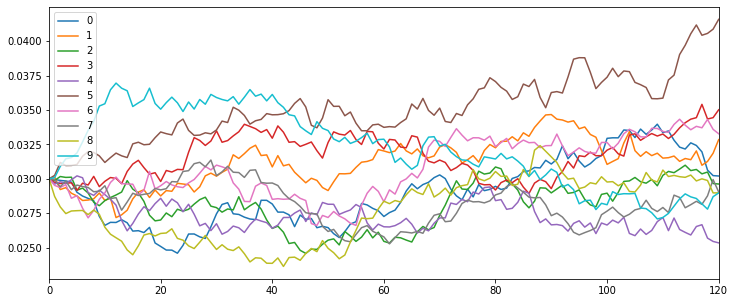

In [6]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5))

In [7]:
# when the speed of mean reversion incresase(a), it reaches the point easily

In [8]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False , figsize=(12,5))
    
import ipywidgets as widgets
from IPython.display import display 

controls= widgets.interactive(show_cir,
                            r_0 = (0, .15, .01),
                            a = (0, 1, .1),
                              b = (0, .15, .01),
                              sigma = (0, .1, .01),
                              n_scenarios = (1, 100) )
                              
display(controls)


interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [9]:
import math 
def cir (n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate a random interest rate evolution over time using the CIR model 
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt=1/steps_per_year
    num_steps=int(n_years*steps_per_year)+1 # because n_years might be a float
    
    
    shock=np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates=np.empty_like(shock)
    rates[0]=r_0
    
    #For the Price Generation 
    h=math.sqrt(a**2+ 2*sigma**2)
    prices=np.empty_like(shock)
    ###
    
    def price(ttm, r):
        _A=((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B=(2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1) )
        _P=_A*np.exp(-_B*r)
        return _P
    prices[0]= price(n_years, r_0)
                 
            
    for step in range(1, num_steps):
        r_t=rates[step-1]
        d_r_t=(a*(b-r_t)*dt)+sigma*np.sqrt(r_t)*shock[step]
        rates[step]= abs(r_t+d_r_t)
        #generate prices at time t as well
        prices[step]=price(n_years-step*dt, rates[step])
            
    rates=pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ##ForPrices
    prices=pd.DataFrame(data=prices, index=range(num_steps))
    ##
    return rates, prices
    

In [10]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False , figsize=(12,5))
    
import ipywidgets as widgets
from IPython.display import display 

controls= widgets.interactive(show_cir_prices,
                            r_0 = (0, .15, .01),
                            a = (0, 1, .1),
                              b = (0, .15, .01),
                              sigma = (0, .1, .01),
                              n_scenarios = (1, 100) )
                              
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [51]:
#This is the evolutino of price of 0 coupon bond. It doesn't matter what will heppen aong the way as
#the price will always converge to 1 which what a zero coupon bond pays eventually
#but what happens along the way matters too

In [11]:
a_0=.75
rates, bond_prices= cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities=bond_prices #changes in the present value of that liability
zcbond_10= pd.Series(data=[1], index=[10]) # zero coupon bound in 10 years
zc_0=erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash=a_0*(rates/12+1).cumprod()# the growth that of a_0 is the initial value times.... and cumpounded value
# you know now how much the value of the asset would be if you have invested in cash 


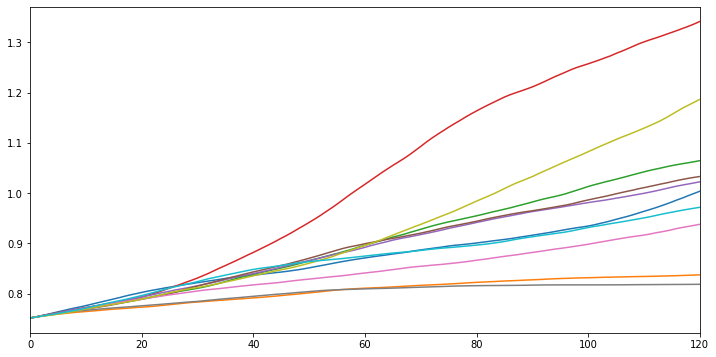

In [12]:
av_cash.plot(legend=False, figsize=(12,6))

This is the evolution of my assets value in 10 diff scenarios.
The liability I am trying to catch is 1M, 10 years from now but I only have 0.74M. So I am going to put them in hedge. I may end up making it as I may not. 
I can be short as the low slope lines represent. If this was a pension fund, it would be a big problem.
So putting all money in hudge is not safe. there is alternatives: 

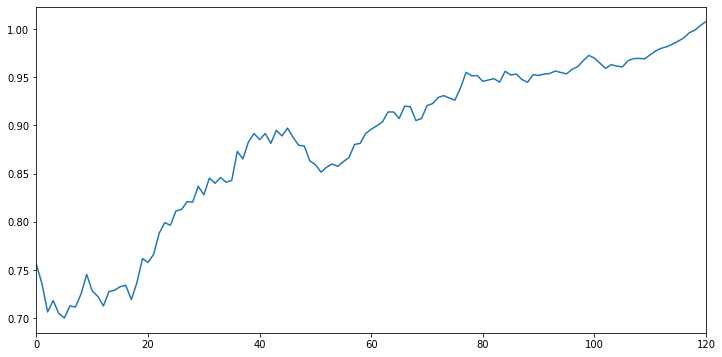

In [13]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

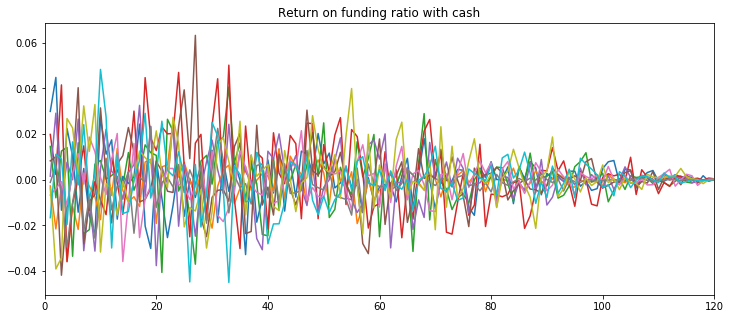

In [14]:
(av_cash/liabilities).pct_change().plot(title='Return on funding ratio with cash', legend=False, figsize=(12,5))

In [18]:
#Funding ratio with cash is very volatile( risky), unlike with zero coupon: 

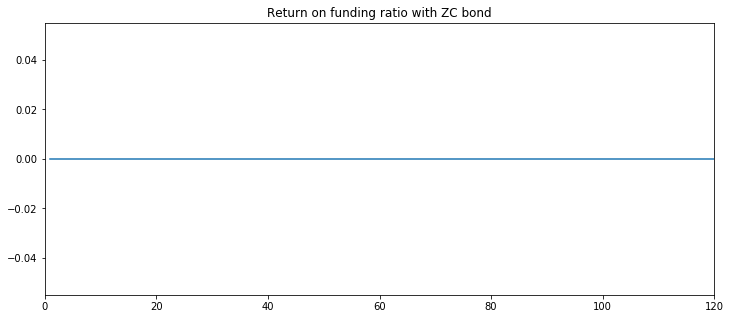

In [24]:
(av_zc_bonds/liabilities).pct_change().plot(title='Return on funding ratio with ZC bond', legend=False, figsize=(12,5))

In [19]:
a_0=0.75
rates, bond_prices=cir(n_scenarios=1000,r_0=0.03, b=0.03 )
liabilities=bond_prices
zc_0=erk.pv(zcbond_10, 0.03)
n_bonds=a_0/zc_0
av_zc_bonds= n_bonds*bond_prices
av_cash=a_0*(rates/12+1).cumprod()



In [21]:
# if i DON T CARE ABOUT THE INTERMEDIATE VALUE BUT I CARE ABOUT THE TERMINAL VALUE:

In [22]:
tfr_cash=av_cash.iloc[-1]/liabilities.iloc[-1] 
tfr_zc_bonds=av_zc_bonds.iloc[-1]/liabilities.iloc[-1] 
#iloc is the int index and -1 is to say I want the last one

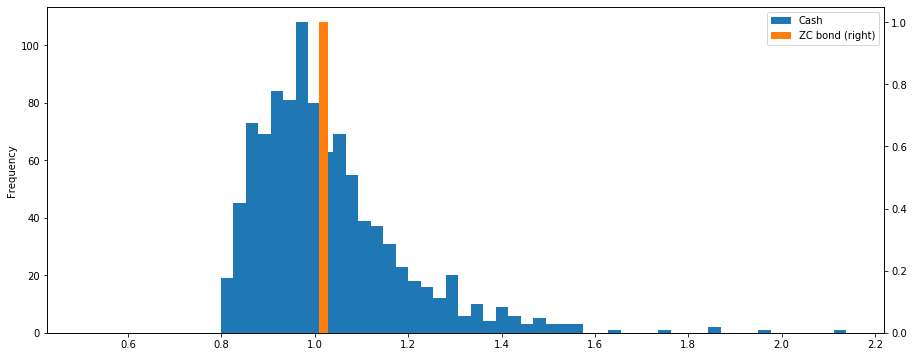

In [23]:
ax=tfr_cash.plot.hist(label='Cash', figsize=(15,6), bins=50, legend=True)

tfr_zc_bonds.plot.hist(ax=ax, label="ZC bond",bins=50, legend=True, secondary_y=True)